In [1]:
import os
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from operator import itemgetter
from collections import defaultdict

import utils as utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [25]:
cwd = os.getcwd()
filename = os.path.join(cwd, '..', 'data', 'cities_5.txt')
print filename

/Users/martin.majer/Projects/KiwiTS/networkx_test/solver/../data/cities_5.txt


In [26]:
start, flights = utils.read_file(filename)
#flights.sort(key=itemgetter(2))

print start
#for flt in flights:
#    print flt

ACZ


('CZB', 'ACZ', {'day': 4, 'weight': 1369})
('CZB', 'VZA', {'day': 1, 'weight': 317})
('CZB', 'VZA', {'day': 2, 'weight': 1111})
('CZB', 'VZA', {'day': 3, 'weight': 262})
('CZB', 'SSA', {'day': 1, 'weight': 1434})
('CZB', 'SSA', {'day': 2, 'weight': 652})
('CZB', 'SSA', {'day': 3, 'weight': 775})
('CZB', 'ZEX', {'day': 1, 'weight': 645})
('CZB', 'ZEX', {'day': 2, 'weight': 1302})
('CZB', 'ZEX', {'day': 3, 'weight': 933})
('ACZ', 'CZB', {'day': 0, 'weight': 1140})
('ACZ', 'VZA', {'day': 0, 'weight': 544})
('ACZ', 'SSA', {'day': 0, 'weight': 628})
('ACZ', 'ZEX', {'day': 0, 'weight': 666})
('VZA', 'CZB', {'day': 1, 'weight': 1281})
('VZA', 'CZB', {'day': 2, 'weight': 366})
('VZA', 'CZB', {'day': 3, 'weight': 818})
('VZA', 'ACZ', {'day': 4, 'weight': 303})
('VZA', 'ZEX', {'day': 1, 'weight': 386})
('VZA', 'ZEX', {'day': 2, 'weight': 79})
('VZA', 'ZEX', {'day': 3, 'weight': 510})
('VZA', 'SSA', {'day': 1, 'weight': 227})
('VZA', 'SSA', {'day': 2, 'weight': 1250})
('VZA', 'SSA', {'day': 3, 'w

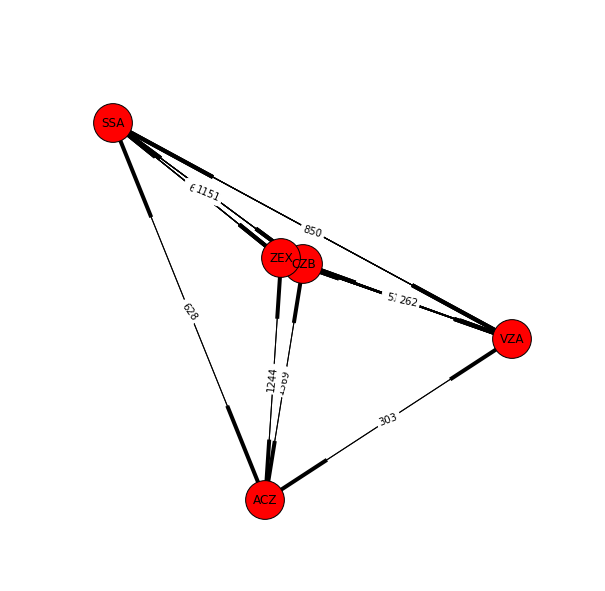

In [34]:
G = nx.MultiDiGraph()
max_day = max(flights, key=itemgetter(2)).DOD

for flt in flights:
    if (flt.FROM == start and flt.DOD == 0) or (flt.TO == start and flt.DOD == max_day)\
       or (start not in [flt.FROM, flt.TO] and flt.DOD != 0 and flt.DOD != max_day):
        #print 'Adding edge:', (flt.FROM, flt.TO), 'for day', flt.DOD
        G.add_edge(flt.FROM, flt.TO, weight=flt.PRICE, day=flt.DOD)
    else:
        #print 'Skipping edge', (flt.FROM, flt.TO), 'for day', flt.DOD
        pass

for e in G.edges(data=True):
    print e

edge_labels = dict([((u, v,), d['weight']) for u, v, d in G.edges(data=True)])
node_labels = {node: node for node in G.nodes()}
pos = nx.spring_layout(G, k=1, iterations=25)

plt.figure(figsize=(10, 10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw(G, pos, node_size=1500)
plt.show()

In [35]:
def nearest_neighbors(G, start):
    to_visit = G.nodes()
    
    cost = 0
    path = [start]
    current_day = 0
    current_city = start
    
    while to_visit:
        current_flights = [(u, v, d) for (u, v, d) in G.edges(current_city, data=True)
                           if d['day'] == current_day and v in to_visit]
        best_flight = min(current_flights, key=lambda (u, v, d): d['weight'])
        
        cost += best_flight[2]['weight']
        current_city = best_flight[1]
        current_day += 1
        
        to_visit.remove(current_city)
        path.append(current_city)
        
    return cost, path
    
cost, path = nearest_neighbors(G, start)
print path
print cost

assert len(np.unique(path)) == len(G.nodes())

['ACZ', 'VZA', 'SSA', 'ZEX', 'CZB', 'ACZ']
2792


# ODPAD

In [ ]:
def goes_back(G, flt_to, flt_from, flt_dod, flt_price):
    source = flt_to + str(flt_dod - 1)
    target = flt_from + str(flt_dod)
    return G.has_edge(source, target) and flt_price == G[source][target]['weight']
    

G = nx.DiGraph()
max_day = flights[-1].DOD#max(flights, key=itemgetter(2)).DOD + 1

for flt in flights:
    flt_from = flt.FROM + str(flt.DOD)
    flt_to = flt.TO + str(flt.DOD + 1)
    
    if flt.FROM == start and flt.DOD == 0:
        #print 'Adding edge:', (flt_from, flt_to), 'for day', flt.DOD
        G.add_edge(flt_from, flt_to, weight=flt.PRICE, day=flt.DOD)
    elif start not in [flt.FROM, flt.TO] and flt.DOD != 0 and flt.DOD != max_day and \
     not goes_back(G, flt.TO, flt.FROM, flt.DOD, flt.PRICE):
        #print 'Adding edge:', (flt_from, flt_to), 'for day', flt.DOD
        G.add_edge(flt_from, flt_to, weight=flt.PRICE, day=flt.DOD)
    elif flt.DOD == max_day and flt.TO == start:
        #print 'Adding edge:', (flt_from, start + 'X'), 'for day', flt.DOD
        G.add_edge(flt_from, start + 'X', weight=flt.PRICE, day=flt.DOD)
    else:
        pass#print '    skipping', (flt_from, flt_to), 'for day', flt.DOD
    

print G.edges(data=True)

edge_labels = dict([((u, v,), d['weight']) for u, v, d in G.edges(data=True)])
node_labels = {node: node for node in G.nodes()}
pos = nx.spring_layout(G, k=1, iterations=25)

plt.figure(figsize=(10, 10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw(G, pos, node_size=1500)
plt.show()

In [ ]:
from heapq import heappush, heappop
from itertools import count

def astar_path(G, source, target):
    def heuristic(u, v):
        return G[v][u]['weight'] / 1000

    c = count()
    queue = [(0, next(c), source, 0, None)]

    enqueued = {}
    explored = {}

    while queue:
        _, __, curnode, dist, parent = heappop(queue)
        
        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path

        if curnode in explored:
            continue

        explored[curnode] = parent

        for neighbor, w in G[curnode].items():
            if neighbor in explored:
                continue
            ncost = w['day']
            h = heuristic(neighbor, curnode)
            enqueued[neighbor] = ncost, h
            heappush(queue, (ncost + h, next(c), neighbor, ncost, curnode))
            
path = astar_path(G, start+str(0), start+'X')
print path

assert len(np.unique([p[:-1] for p in path])) == len(path)-1

In [ ]:

def write_results(filename, cost, path_edges, G):
    with open(filename, 'w') as fw:
        fw.write('{}\n'.format(cost))
        for edge in path_edges:
            flight_from = edge[0][:-1]
            flight_to = edge[1][:-1]
            flight_dod = edge[0][-1]
            flight_price = G[edge[0]][edge[1]]['weight']
            fw.write('{} {} {} {}\n'.format(flight_from, flight_to, flight_dod, flight_price))

In [ ]:
path_edges = zip(*[path[i:] for i in xrange(2)])

cost = 0

for edge in path_edges:
    cost += G[edge[0]][edge[1]]['weight']

print path_edges
print cost

In [ ]:
outfile = os.path.join(cwd, '..', 'results', 'out.txt')
write_results(outfile, cost, path_edges, G)